## mnist
classify handwritten digits 0-9

In [14]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

print('imported modules.')

imported modules.


Using TensorFlow backend.


## Data
dataset consists of 42,000 obs, one col of labels, 784 cols of pixel values

In [30]:
train = pd.read_csv("train.csv")
print('train shape: {}.'.format(train.shape))
train.head()

train shape: (42000, 785).


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


labels have shape: (42000,).
preds have shape: (42000, 784)
counts of labels: 
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


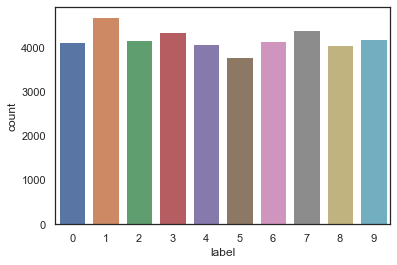

In [31]:
y = train.iloc[:,0]
X_train = train.iloc[:,1:]
print('labels have shape: {}.'.format(y.shape))
print('preds have shape: {}'.format(X_train.shape))
print('counts of labels: ')
print(y.value_counts())
sns.countplot(y)

In [32]:
X_test = pd.read_csv("test.csv")
X_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Normalization
Normalize to be between (0,1) instead of (0,255). Calculate across pixel means by label.

In [45]:
X_train.groupby(y).mean().mean(axis = 1)

label
0    44.173989
1    19.373044
2    38.100892
3    36.122689
4    30.909085
5    32.953980
6    35.376170
7    29.249036
8    38.500189
9    31.318559
dtype: float64

In [46]:
X_train = X_train / 255
X_test = X_test / 255

In [47]:
X_train.groupby(y).mean().mean(axis = 1)

label
0    0.173231
1    0.075973
2    0.149415
3    0.141658
4    0.121212
5    0.129231
6    0.138730
7    0.114702
8    0.150981
9    0.122818
dtype: float64

## Rearrange Data into matrices
size (28x28x1) since b&w images

In [50]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

In [62]:
X_train[0].shape

(28, 28, 1)

In [55]:
y_train = to_categorical(y, num_classes = 10)
y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Split into training and test sets

In [57]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

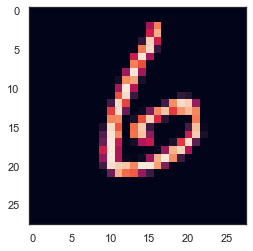

In [60]:
plt.imshow(X_train[2][:,:,0])

## Fit a CNN model

In [63]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [64]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [65]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [66]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [67]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [68]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), verbose = 2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
 - 12s - loss: 0.2232 - accuracy: 0.9292 - val_loss: 0.0611 - val_accuracy: 0.9805
Epoch 2/30
 - 5s - loss: 0.0701 - accuracy: 0.9788 - val_loss: 0.0432 - val_accuracy: 0.9869
Epoch 3/30
 - 5s - loss: 0.0542 - accuracy: 0.9837 - val_loss: 0.0460 - val_accuracy: 0.9871
Epoch 4/30
 - 5s - loss: 0.0433 - accuracy: 0.9868 - val_loss: 0.0337 - val_accuracy: 0.9905
Epoch 5/30
 - 5s - loss: 0.0373 - accuracy: 0.9885 - val_loss: 0.0442 - val_accuracy: 0.9862
Epoch 6/30
 - 5s - loss: 0.0352 - accuracy: 0.9898 - val_loss: 0.0305 - val_accuracy: 0.9914
Epoch 7/30
 - 5s - loss: 0.0328 - accuracy: 0.9896 - val_loss: 0.0407 - val_accuracy: 0.9907
Epoch 8/30
 - 5s - loss: 0.0299 - accuracy: 0.9910 - val_loss: 0.0299 - val_accuracy: 0.9914
Epoch 9/30
 - 5s - loss: 0.0291 - accuracy: 0.9915 - val_loss: 0.0469 - val_accuracy: 0.9874
Epoch 10/30
 - 5s - loss: 0.0294 - accuracy: 0.9915 - val_loss: 0.0322 - val_accuracy: 0.9902
Epoch 11/30
 - 5s -

## Model Evaluation

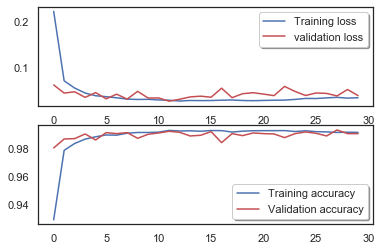

In [71]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

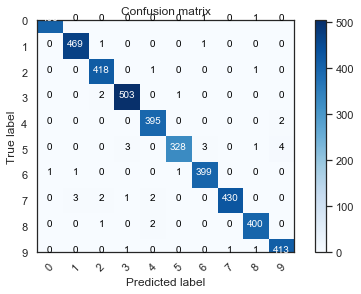

In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 